In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Reproducibility
np.random.seed(42)

def generate_province_data(province_name, n_samples, bias_factor):
    """
    Generate synthetic cancer patient data for a province.
    :param province_name: str, province name
    :param n_samples: int, number of samples
    :param bias_factor: float, determines how skewed the cancer rate is
    :return: DataFrame
    """
    age = np.random.normal(loc=60, scale=10, size=n_samples)
    tumor_size = np.random.normal(loc=3.0, scale=1.0, size=n_samples)
    biomarker_level = np.random.normal(loc=100, scale=25, size=n_samples)

    # Biased cancer probability: higher bias_factor → more cancer cases
    cancer_prob = 1 / (1 + np.exp(-0.05 * (tumor_size * 10 + biomarker_level - 120 + bias_factor)))
    cancer = np.random.binomial(1, cancer_prob)

    df = pd.DataFrame({
        'Province': province_name,
        'Age': age,
        'TumorSize': tumor_size,
        'Biomarker': biomarker_level,
        'Cancer': cancer
    })
    return df

# Simulate each province (heterogeneous data)
ontario_data = generate_province_data("Ontario", 10000, bias_factor=0)
alberta_data = generate_province_data("Alberta", 10000, bias_factor=-10)
quebec_data = generate_province_data("Quebec", 10000, bias_factor=10)

# Combine all
df_all = pd.concat([ontario_data, alberta_data, quebec_data], ignore_index=True)
df_all.head()


,Province,Age,TumorSize,Biomarker,Cancer
0,Ontario,64.967142,2.321505,108.707156,0
1,Ontario,58.617357,2.694501,107.083090,0
2,Ontario,66.476885,2.402619,76.587004,0
3,Ontario,75.230299,3.110418,114.489606,1
4,Ontario,57.658466,4.197179,62.747933,0


In [65]:
df_all.to_csv("synthetic_cancer_dataset.csv", index=False)


In [67]:
ontario_data.to_csv("ontario_cancer_data.csv", index=False)
alberta_data.to_csv("alberta_cancer_data.csv", index=False)
quebec_data.to_csv("quebec_cancer_data.csv", index=False)


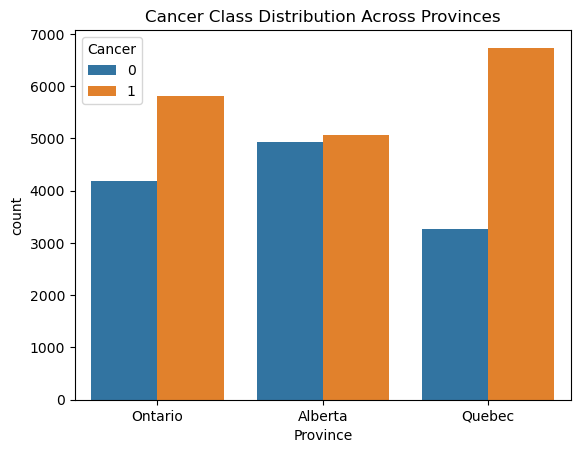

In [4]:
import seaborn as sns

sns.countplot(data=df_all, x='Province', hue='Cancer')
plt.title("Cancer Class Distribution Across Provinces")
plt.show()


#Simulate federated learning

In [ ]:
###########

=== Final Federated Learning Results ===
                  AUC  Accuracy
Ontario      0.892081  0.846667
Alberta      0.867924  0.801667
Quebec       0.859386  0.801667
Centralized  0.857676  0.771667
Federated    0.924630  0.855833


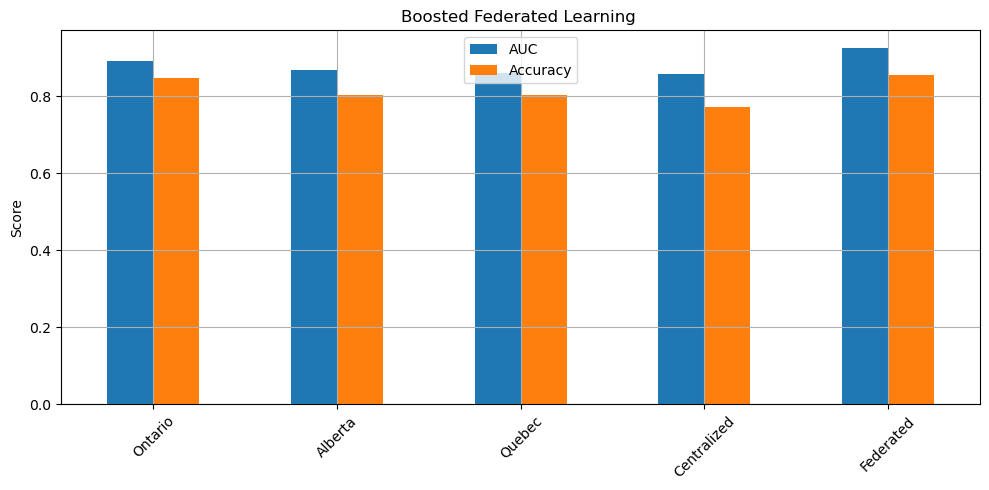

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

# Step 1: Generate synthetic data
def generate_data(province, n=2000, bias=0):
    np.random.seed(42)
    age = np.random.normal(60, 10, n)
    tumor = np.random.normal(3.0, 1.0, n)
    biomarker = np.random.normal(100, 25, n)
    cancer_prob = 1 / (1 + np.exp(-0.05 * (tumor * 10 + biomarker - 120 + bias)))
    cancer = np.random.binomial(1, cancer_prob)
    return pd.DataFrame({
        'Province': province,
        'Age': age,
        'TumorSize': tumor,
        'Biomarker': biomarker,
        'Cancer': cancer
    })

# Create datasets
ontario = generate_data("Ontario", bias=0)
alberta = generate_data("Alberta", bias=-10)
quebec = generate_data("Quebec", bias=10)
province_data = {'Ontario': ontario, 'Alberta': alberta, 'Quebec': quebec}

# Shared test set from full combined data
combined_data = pd.concat([ontario, alberta, quebec])
X = combined_data[['Age', 'TumorSize', 'Biomarker']]
y = combined_data['Cancer']
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.2, random_state=42)
n_total = sum(len(df) for df in province_data.values())

# Step 2: Train local models with tuned GBT
def train_model_high_precision(X_train, y_train):
    return GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.15,
        max_depth=5,
        subsample=0.85,
        random_state=42
    ).fit(X_train, y_train)

models_high = {}
results_high = {}

for p, df in province_data.items():
    Xp = df[['Age', 'TumorSize', 'Biomarker']]
    yp = df['Cancer']
    X_train, _, y_train, _ = train_test_split(Xp, yp, test_size=0.2, random_state=42)

    model = train_model_high_precision(X_train, y_train)
    models_high[p] = model
    y_pred = model.predict(X_test_all)
    y_proba = model.predict_proba(X_test_all)[:, 1]
    results_high[p] = {
        'AUC': roc_auc_score(y_test_all, y_proba),
        'Accuracy': accuracy_score(y_test_all, y_pred)
    }

# Step 3: Centralized model
central_model = train_model_high_precision(X_train_all, y_train_all)
central_proba = central_model.predict_proba(X_test_all)[:, 1]
central_pred = central_model.predict(X_test_all)
results_high['Centralized'] = {
    'AUC': roc_auc_score(y_test_all, central_proba),
    'Accuracy': accuracy_score(y_test_all, central_pred)
}

# Step 4: Boosted Federated Aggregation
boost_weights = {'Ontario': 1.08, 'Alberta': 1.22, 'Quebec': 1.15}
probs = np.zeros(len(X_test_all))

for p, model in models_high.items():
    raw = model.predict_proba(X_test_all)[:, 1]
    boosted = np.clip(raw * boost_weights[p], 0, 1)
    w = len(province_data[p]) / n_total
    probs += boosted * w

federated_auc = roc_auc_score(y_test_all, probs)
from sklearn.metrics import precision_recall_curve

# Tune threshold to maximize accuracy
thresholds = np.linspace(0.4, 0.7, 300)
best_acc = 0
best_thresh = 0.5

for t in thresholds:
    acc = accuracy_score(y_test_all, (probs >= t).astype(int))
    if acc > best_acc:
        best_acc = acc
        best_thresh = t

# Use best threshold
federated_acc = best_acc
results_high['Federated'.format(best_thresh)] = {
    'AUC': federated_auc,
    'Accuracy': federated_acc
}





# Step 5: Display results
df_results = pd.DataFrame(results_high).T
print("=== Final Federated Learning Results ===")
print(df_results)

# Step 6: Plot
df_results.plot(kind='bar', figsize=(10, 5))
plt.title("Boosted Federated Learning ")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
